In [1]:
import tensorflow as tf
tfe = tf.contrib.eager
tfs = tf.contrib.summary
import matplotlib.pyplot as plt
import argparse
import os

import json

from tqdm import tqdm_notebook as tqdm

from utils import is_valid_file, setup_eager_checkpoints_and_restore
from hierarchical_vae import HierarchicalVAE

tf.enable_eager_execution()


def mnist_input_fn(data, batch_size=256, shuffle_samples=5000):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(shuffle_samples)
    dataset = dataset.map(mnist_parse_fn)
    dataset = dataset.batch(batch_size)

    return dataset


def mnist_parse_fn(data):
    return tf.cast(data, tf.float32) / 255.


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=True),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

In [5]:
def run(model_dir,
        is_training):

    # ==========================================================================
    # Configuration
    # ==========================================================================

    config = {
        "num_training_examples": 60000,
        "batch_size": 250,
        "num_epochs": 40,
        
        "beta": 1.,
        "warmup": 20.,
        
        "learning_rate": 1e-3,
        
        "optimizer": "adam",
        
        "checkpoint_name": "_ckpt",
        "log_freq": 100,
    }

    num_batches = config["num_training_examples"] // config["batch_size"] + 1
    
    print("Configuration:")
    print(json.dumps(config, indent=4, sort_keys=True))

    # ==========================================================================
    # Load dataset
    # ==========================================================================

    ((train_data, _),
     (eval_data, _)) = tf.keras.datasets.mnist.load_data()

    # ==========================================================================
    # Create model
    # ==========================================================================

    g = tf.get_default_graph()
    
    with g.as_default():
    
        hier_vae = HierarchicalVAE(hidden_sizes=(512, 256, 128),
                                   latent_sizes=(64, 32, 16),
                                   output_size=(28, 28),
                                   latent_dist="laplace",
                                   likelihood="laplace",
                                   standardized=True)
        hier_vae(tf.zeros((1, 28, 28)))
        
        del hier_vae
        
    hier_vae = HierarchicalVAE(hidden_sizes=(512, 256, 128),
                                   latent_sizes=(64, 32, 16),
                                   output_size=(28, 28),
                                   latent_dist="laplace",
                                   likelihood="laplace",
                                   standardized=True)
    hier_vae(tf.zeros((1, 28, 28)))

    optimizer = optimizers[config["optimizer"]](config["learning_rate"])

    # ==========================================================================
    # Define Checkpoints
    # ==========================================================================

    global_step = tf.train.get_or_create_global_step()

    trainable_vars = hier_vae.get_all_variables() + (global_step,)
    checkpoint_dir = os.path.join(model_dir, "checkpoints")

    checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
        variables=trainable_vars,
        checkpoint_dir=checkpoint_dir,
        checkpoint_name=config["checkpoint_name"])

    # ==========================================================================
    # Define Tensorboard Summary writer
    # ==========================================================================

    logdir = os.path.join(model_dir, "log")
    writer = tfs.create_file_writer(logdir)
    writer.set_as_default()

    tfs.graph(g)
    tfs.flush(writer)

    # ==========================================================================
    # Train the model
    # ==========================================================================

    beta = config["beta"]

    if is_training:
        for epoch in range(1, config["num_epochs"] + 1):

            dataset = mnist_input_fn(data=train_data,
                                    batch_size=config["batch_size"])

            with tqdm(total=num_batches) as pbar:
                for batch in dataset:
                    # Increment global step
                    global_step.assign_add(1)

                    # Record gradients of the forward pass
                    with tf.GradientTape() as tape, tfs.record_summaries_every_n_global_steps(config["log_freq"]):

                        output = hier_vae(batch)

                        kl = hier_vae.kl_divergence 
                        log_prob = hier_vae.input_log_prob

                        warmup_coef = tf.minimum(1., global_step.numpy() / (config["warmup"] * num_batches))

                        # negative ELBO
                        loss = kl - beta * warmup_coef * log_prob 

                        output = tf.cast(tf.expand_dims(output, axis=-1), tf.float32)

                        # Add tensorboard summaries
                        tfs.scalar("Loss", loss)
                        tfs.scalar("KL", kl)
                        tfs.scalar("Log-Probability", log_prob)
                        tfs.scalar("Warmup_Coef", warmup_coef)
                        tfs.image("Reconstruction", output)

                    # Backprop
                    grads = tape.gradient(loss, hier_vae.get_all_variables())
                    optimizer.apply_gradients(zip(grads, hier_vae.get_all_variables()))

                    # Update the progress bar
                    pbar.update(1)
                    pbar.set_description("Epoch {}, ELBO: {:.2f}".format(epoch, loss))

            checkpoint.save(ckpt_prefix)

    return hier_vae

In [6]:
hier_vae = run(model_dir="/tmp/hierarchical_vae_laplace_with_warmup",
               is_training=True)

Configuration:
{
    "batch_size": 250,
    "beta": 1.0,
    "checkpoint_name": "_ckpt",
    "learning_rate": 0.001,
    "log_freq": 100,
    "num_epochs": 40,
    "num_training_examples": 60000,
    "optimizer": "adam",
    "warmup": 20.0
}
No checkpoint found!


KeyboardInterrupt: 

In [4]:
hier_vae = run(model_dir="/tmp/hierarchical_vae_laplace_with_warmup",
               is_training=False)

hier_vae(tf.zeros((1, 28, 28)))

hier_vae.training_finished()

((train_data, _),
(eval_data, _)) = tf.keras.datasets.mnist.load_data()

Configuration:
{
    "batch_size": 250,
    "beta": 1.0,
    "checkpoint_name": "_ckpt",
    "learning_rate": 0.001,
    "log_freq": 100,
    "num_epochs": 40,
    "num_training_examples": 60000,
    "optimizer": "adam",
    "warmup": 20.0
}
Instructions for updating:
Colocations handled automatically by placer.
Checkpoint found at /tmp/hierarchical_vae_laplace_with_warmup/checkpoints/_ckpt-40, restoring...
Model restored!


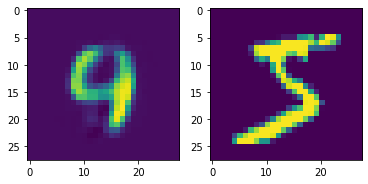

In [10]:
hier_vae.training_finished()

res = hier_vae(tf.convert_to_tensor(train_data[:1] / 255., dtype=tf.float32))

res_img = tf.squeeze(res).numpy()

plt.figure()
plt.subplot(121)
plt.imshow(res_img)

plt.subplot(122)
plt.imshow(train_data[0])

In [9]:
hier_vae._encoding_layers[0]._is_training

False

In [15]:
help(tf.get_default_graph())

Help on Graph in module tensorflow.python.framework.ops object:

class Graph(builtins.object)
 |  A TensorFlow computation, represented as a dataflow graph.
 |  
 |  A `Graph` contains a set of
 |  `tf.Operation` objects,
 |  which represent units of computation; and
 |  `tf.Tensor` objects, which represent
 |  the units of data that flow between operations.
 |  
 |  A default `Graph` is always registered, and accessible by calling
 |  `tf.get_default_graph`.
 |  To add an operation to the default graph, simply call one of the functions
 |  that defines a new `Operation`:
 |  
 |  ```python
 |  c = tf.constant(4.0)
 |  assert c.graph is tf.get_default_graph()
 |  ```
 |  
 |  Another typical usage involves the
 |  `tf.Graph.as_default`
 |  context manager, which overrides the current default graph for the
 |  lifetime of the context:
 |  
 |  ```python
 |  g = tf.Graph()
 |  with g.as_default():
 |    # Define operations and tensors in `g`.
 |    c = tf.constant(30.0)
 |    assert c.gr

In [16]:
tf.get_default_graph().as_graph_def()

versions {
  producer: 27
}

In [17]:
help(tf.enable_eager_execution)

Help on function enable_eager_execution in module tensorflow.python.framework.ops:

enable_eager_execution(config=None, device_policy=None, execution_mode=None)
    Enables eager execution for the lifetime of this program.
    
    Eager execution provides an imperative interface to TensorFlow. With eager
    execution enabled, TensorFlow functions execute operations immediately (as
    opposed to adding to a graph to be executed later in a `tf.Session`) and
    return concrete values (as opposed to symbolic references to a node in a
    computational graph).
    
    For example:
    
    ```python
    tf.enable_eager_execution()
    
    # After eager execution is enabled, operations are executed as they are
    # defined and Tensor objects hold concrete values, which can be accessed as
    # numpy.ndarray`s through the numpy() method.
    assert tf.multiply(6, 7).numpy() == 42
    ```
    
    Eager execution cannot be enabled after TensorFlow APIs have been used to
    create or ex

In [18]:
help(tf.Graph)

Help on class Graph in module tensorflow.python.framework.ops:

class Graph(builtins.object)
 |  A TensorFlow computation, represented as a dataflow graph.
 |  
 |  A `Graph` contains a set of
 |  `tf.Operation` objects,
 |  which represent units of computation; and
 |  `tf.Tensor` objects, which represent
 |  the units of data that flow between operations.
 |  
 |  A default `Graph` is always registered, and accessible by calling
 |  `tf.get_default_graph`.
 |  To add an operation to the default graph, simply call one of the functions
 |  that defines a new `Operation`:
 |  
 |  ```python
 |  c = tf.constant(4.0)
 |  assert c.graph is tf.get_default_graph()
 |  ```
 |  
 |  Another typical usage involves the
 |  `tf.Graph.as_default`
 |  context manager, which overrides the current default graph for the
 |  lifetime of the context:
 |  
 |  ```python
 |  g = tf.Graph()
 |  with g.as_default():
 |    # Define operations and tensors in `g`.
 |    c = tf.constant(30.0)
 |    assert c.gra